# Download text

### First we want to extract some C++ code from github. How can we do that?

### I think we should parse trending c++ page 'https://github.com/trending/c++?since=weekly'

In [1]:
from bs4 import BeautifulSoup

import tensorflow as tf

import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
import pprint
import time

import urllib
from datetime import datetime

In [2]:
source_name = urllib.request.urlretrieve('https://github.com/trending/c++?since=weekly')[0]
output_name = 'links'

limit_repos = 100
repos = []
counter = 0

with open(output_name, 'w') as output, \
     open(source_name, 'r') as source:
    content = source.read()
    
    soup = BeautifulSoup(content, 'lxml')
    
    for target in soup.find_all('h1', attrs={'class' : 'h3 lh-condensed'}):
        if counter == limit_repos:
            break
        
        link = target.a['href']

        counter += 1
        output.write('https://github.com' + link + '\n')

### 'download.sh' clones the repositories and filters C / C ++ files into the 'src_files' directory. After that, all files converted to utf-8 encoding will be combined into a single 'src' file.

In [3]:
 import getpass
 import os

 password = getpass.getpass()
 command = "sudo -S ./download.sh"
 os.system('echo %s | %s' % (password, command))

········


256

# Prepare and encode text

In [26]:
with open('src', 'rb') as src_file:
    src = src_file.read().decode(encoding='utf-8')

In [27]:
print(src[:500])

#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <unistd.h>

#include <sys/types.h>
#include <sys/stat.h>
#include <fcntl.h>

#include "../../objs/include/srs_librtmp.h"

int parse_flv(srs_flv_t flv);
int main(int argc, char** argv)
{
    int ret = 0;
    
    // user options.
    char* in_flv_file;
    // flv handler
    srs_flv_t flv;
    
    printf("parse and show flv file detail.\n");
    printf("srs(ossrs) client librtmp library.\n");
    printf("version: %d.%d.%d\n", sr


In [28]:
vocab = sorted(set(src))

print(f'{len(vocab)} unique characters')

300 unique characters


### That's a lot of symbols. I don't all of them matters.

In [29]:
# vocab

In [30]:
vocab = list(vocab)
vocab = vocab[:vocab.index('~')+1]
vocab.remove('\x0c')
vocab = sorted(set(vocab))

In [31]:
print(f'{len(vocab)} unique characters')

97 unique characters


In [32]:
new_src = "".join(filter(lambda x: x in vocab, src))

print(new_src[:500])

#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <unistd.h>

#include <sys/types.h>
#include <sys/stat.h>
#include <fcntl.h>

#include "../../objs/include/srs_librtmp.h"

int parse_flv(srs_flv_t flv);
int main(int argc, char** argv)
{
    int ret = 0;
    
    // user options.
    char* in_flv_file;
    // flv handler
    srs_flv_t flv;
    
    printf("parse and show flv file detail.\n");
    printf("srs(ossrs) client librtmp library.\n");
    printf("version: %d.%d.%d\n", sr


In [33]:
print(len(src), len(new_src))

78099017 78090479


### Next thing we are going to do is cut too long commentaries (>10 symbols).

In [34]:
def clean_from_commentaries(text):
    result = []
    comment_length = 10
    stack = []
    # empty is fine
    # '/*' should meet '*/'
    # '//' should meet '\n'
    memory = []
    for i in range(len(text)-1):
        if stack:
            if stack[-1] == '/*' and text[i:i+2] == '*/' \
               or stack[-1] == '//' and text[i] == '\n':
                
                result.extend(memory[:comment_length])
                
                if text[i] == '\n':
                    result.append('\n')
                else:
                    result.append('*')
                    
                stack.pop()
                
                memory = []
            else:
                memory.append(text[i])
            
            continue
        elif text[i:i+2] == '/*' or text[i:i+2] == '//':
            stack.append(text[i:i+2])
        
        result.append(text[i])
    
    result.extend(memory[:comment_length])

    result.append(text[-1])
    
    return "".join(result)

In [35]:
final_src = clean_from_commentaries(new_src)

print(len(final_src), len(new_src))

63214375 78090479


In [36]:
def delete_suspicious_lines(text):
    limit_repeats = 10
    limit_length = 150
    
    lines = text.split('\n')
    
    result = []
    
    memory = []
    
    curr_length = -1
    
    for line in lines:
        if len(line) > limit_length:
            continue
        
        if len(line) != curr_length:
            curr_length = len(line)
            
            if len(memory) <= limit_repeats:
                result.extend(memory)
            
            memory = []
        
        memory.append(line)
    
    if len(memory) <= limit_repeats:
        result.extend(memory)
    
    return "\n".join(result)

In [37]:
final_src = delete_suspicious_lines(final_src)

print(len(final_src), len(new_src))

61520069 78090479


In [38]:
new_src = final_src

In [39]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

with open('encoding_table', 'wb') as f:
    pickle.dump(char2idx, f)
    pickle.dump(idx2char, f)

In [40]:
new_src_as_int = [char2idx[c] for c in new_src]

In [41]:
print(new_src_as_int[:250])

[5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 85, 86, 70, 75, 81, 16, 74, 32, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 85, 86, 84, 75, 80, 73, 16, 74, 32, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 85, 86, 70, 78, 75, 68, 16, 74, 32, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 87, 80, 75, 85, 86, 70, 16, 74, 32, 1, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 85, 91, 85, 17, 86, 91, 82, 71, 85, 16, 74, 32, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 85, 91, 85, 17, 85, 86, 67, 86, 16, 74, 32, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 30, 72, 69, 80, 86, 78, 16, 74, 32, 1, 1, 5, 75, 80, 69, 78, 87, 70, 71, 2, 4, 16, 16, 17, 16, 16, 17, 81, 68, 76, 85, 17, 75, 80, 69, 78, 87, 70, 71, 17, 85, 84, 85, 65, 78, 75, 68, 84, 86, 79, 82, 16, 74, 4, 1, 1, 75, 80, 86, 2, 82, 67, 84, 85, 71, 65, 72, 78, 88, 10, 85, 84, 85, 65, 72, 78, 88, 65, 86, 2, 72, 78, 88, 11, 29, 1, 75, 80, 86, 2, 79, 67, 75, 80, 10, 75, 80, 86, 2, 67, 84, 73, 69, 14, 2, 69, 74, 67, 84, 12, 12, 2, 67, 84, 73, 88]


In [42]:
with open('encoded_src', 'wb') as f:
    arr = np.array(new_src_as_int)
    np.save(f, arr)

# import getpass
# import os

# password = getpass.getpass()
# command = "sudo -S rm -r src"
# os.system('echo %s | %s' % (password, command))

# Dataset workflow

In [2]:
def load_char2idx_idx2char():
    global char2idx, idx2char
    
    with open('encoding_table', 'rb') as l_f:
        char2idx = pickle.load(l_f)
        idx2char = pickle.load(l_f)


load_char2idx_idx2char()

with open('encoded_src', 'rb') as f:
    ds_src = np.load(f)
    
ds = tf.data.Dataset.from_tensor_slices(ds_src)

In [3]:
seq_length = 250

ds = ds.batch(seq_length+1, drop_remainder=True)

In [4]:
def to_train_test(p_sequence):
    l_input  = p_sequence[:-1]
    l_output = p_sequence[1:]
    return l_input, l_output

ds = ds.map(to_train_test, num_parallel_calls=8)

In [5]:
for input, target in ds.take(1):
    print(''.join(idx2char[input.numpy()]))
    print()
    print(''.join(idx2char[target.numpy()]))

#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <unistd.h>

#include <sys/types.h>
#include <sys/stat.h>
#include <fcntl.h>

#include "../../objs/include/srs_librtmp.h"

int parse_flv(srs_flv_t flv);
int main(int argc, char** argv

include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <unistd.h>

#include <sys/types.h>
#include <sys/stat.h>
#include <fcntl.h>

#include "../../objs/include/srs_librtmp.h"

int parse_flv(srs_flv_t flv);
int main(int argc, char** argv)


In [6]:
def train_test_split(p_dataset, p_ds_size, p_test_portion=0.2):
    train_len = int(p_ds_size * (1 - p_test_portion))
    train = p_dataset.take(train_len)
    test = p_dataset.skip(train_len)
    
    return train, train_len, test

In [7]:
ds_size = len(ds_src) // (seq_length + 1)
train, train_size, test = train_test_split(ds, ds_size, 0.1)

In [8]:
# taking 1/16 of it to speed up training
train_size //= 16
train = train.take(train_size)

In [9]:
batch_size = 64

train = train.shuffle(ds_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(2)
train_size = train_size // batch_size


test = test.batch(batch_size, drop_remainder=True).prefetch(2)

train

<PrefetchDataset shapes: ((64, 250), (64, 250)), types: (tf.int64, tf.int64)>

In [15]:
vocab_size = len(idx2char)

# Simple RNN construction and tuning

In [69]:
def build_rnn(p_units, 
              p_embedding_dim,  
              p_learning_rate=0.001,
              p_vocab_size=vocab_size,
              p_batch_size=batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            p_vocab_size, 
            p_embedding_dim,
            batch_input_shape=[p_batch_size, None]
        ),
        tf.keras.layers.SimpleRNN(
            p_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True # only for less complicated text generation
        ),
        tf.keras.layers.Dense(p_vocab_size)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(p_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [70]:
def plot(p_datas, p_label, p_per, p_names):
    plt.figure(figsize=(10,5))
    
    for data, name in zip(p_datas, p_names):
        plt.plot(data, label=name)
    
    plt.title(f'model {p_label}')
    plt.ylabel(f'{p_label}')
    plt.xlabel(f'{p_per}')
    plt.legend()
    plt.show()

## Simple RNN training jupyter-cells

### Normal training

In [19]:
rnn_units = 1024
embedding_dim = 256

model = build_rnn(rnn_units, embedding_dim, 0.001)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24832     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 1024)          1311744   
_________________________________________________________________
dense (Dense)                (64, None, 97)            99425     
Total params: 1,436,001
Trainable params: 1,436,001
Non-trainable params: 0
_________________________________________________________________


In [140]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

## Training with gradient trace

In [135]:
rnn_units = 1024
embedding_dim = 256

model = build_rnn(rnn_units, embedding_dim, 0.001)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (64, None, 256)           24832     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (64, None, 1024)          1311744   
_________________________________________________________________
dense_9 (Dense)              (64, None, 97)            99425     
Total params: 1,436,001
Trainable params: 1,436,001
Non-trainable params: 0
_________________________________________________________________


In [136]:
epochs = 20

In [160]:
@tf.function
def grads_norms(p_grads):
    norms = []
    for grad in p_grads:
        if type(grad) == tf.python.framework.indexed_slices.IndexedSlices:
            grad = grad.values
            
        norm = tf.norm(grad)
        
        norms.append(norm)
        
    return norms 

@tf.function
def train_step(p_model, p_input, p_target):
    with tf.GradientTape() as tape:
        predictions = p_model(p_input)
        
        loss = tf.reduce_mean(
            p_model.loss(p_target, predictions)
        )
        
        accuracy = tf.reduce_mean(
            tf.keras.metrics.sparse_categorical_accuracy(
                p_target, 
                predictions
            )
        )
    grads = tape.gradient(loss, p_model.trainable_variables)
    
    p_model.optimizer.apply_gradients(zip(grads, p_model.trainable_variables))

    return loss, accuracy, grads_norms(grads)

@tf.function
def test_step(p_model, p_input, p_target):
    predictions = p_model(p_input)
    
    accuracy = tf.reduce_mean(
        tf.keras.metrics.sparse_categorical_accuracy(
            p_target, 
            predictions
        )
    )
    
    return accuracy

def advanced_training(p_model, p_epochs, p_train, p_test, p_train_size):
    class Dummy:
        pass
    
    result = Dummy()
    
    result.grads_per_batch = []
    result.loss_per_epoch = []
    result.train_accuracy_per_epoch = []
    result.test_accuracy_per_epoch = []

    for epoch in range(p_epochs):
        start = time.time()

        p_model.reset_states()
        p_train = p_train.shuffle(p_train_size)

        loss_per_batch = []
        accuracy_per_batch = []
        for (idx_batch, (input, target)) in enumerate(p_train):
            loss, accuracy, grads = train_step(p_model, input, target)

            accuracy_per_batch.append(accuracy.numpy())

            grads = [grad.numpy() for grad in grads] # to calc np.mean later

            result.grads_per_batch.append(grads)
            loss_per_batch.append(loss)

            template = 'Batch {}/{}\t\tLoss {}'
            if idx_batch % 50 == 0:
                print(template.format(idx_batch + 1, train_size, loss))

        result.loss_per_epoch.append(loss_per_batch)

        train_accuracy = np.mean(accuracy_per_batch)
        result.train_accuracy_per_epoch.append(train_accuracy)

        accuracy_per_batch = []
        for input, target in p_test:
            accuracy = test_step(p_model, input, target)
            accuracy_per_batch.append(accuracy.numpy())

        test_accuracy = np.mean(accuracy_per_batch)
        result.test_accuracy_per_epoch.append(test_accuracy)

        print('#{} epoch completed in {} sec\n'.format(epoch + 1, time.time() - start))
        print('Train acc {}\t\tTest acc {}'.format(train_accuracy, test_accuracy))
        
    return result

In [164]:
model_rnn = build_rnn(rnn_units, embedding_dim, 0.001)
model_rnn.fit(train, epochs=13, validation_data=test)

Epoch 1/13
535/535 [==============================] - 135s 253ms/step - loss: 2.1308 - sparse_categorical_accuracy: 0.4969 - val_loss: 2.5098 - val_sparse_categorical_accuracy: 0.4199
Epoch 2/13
535/535 [==============================] - 133s 248ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.6817 - val_loss: 2.3939 - val_sparse_categorical_accuracy: 0.4619
Epoch 3/13
535/535 [==============================] - 135s 252ms/step - loss: 1.0232 - sparse_categorical_accuracy: 0.7372 - val_loss: 2.3743 - val_sparse_categorical_accuracy: 0.4751
Epoch 4/13
535/535 [==============================] - 133s 249ms/step - loss: 0.9102 - sparse_categorical_accuracy: 0.7638 - val_loss: 2.4053 - val_sparse_categorical_accuracy: 0.4813
Epoch 5/13
535/535 [==============================] - 134s 250ms/step - loss: 0.8420 - sparse_categorical_accuracy: 0.7800 - val_loss: 2.4408 - val_sparse_categorical_accuracy: 0.4822
Epoch 6/13
535/535 [==============================] - 133s 248ms/step - loss: 0.

### Training completion

In [165]:
model_rnn.save('rnn_model')

INFO:tensorflow:Assets written to: rnn_model/assets


In [ ]:
history = model.history

## Different learning rates

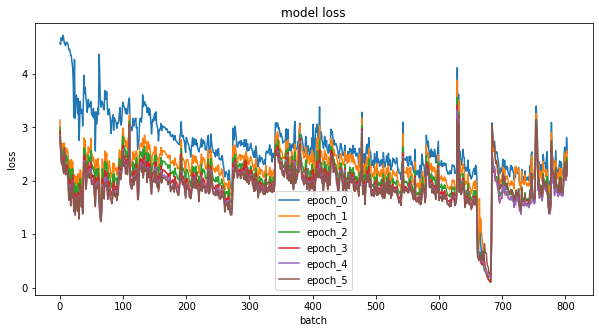

In [45]:
# learning rate = 0.001
# batch size = 256
plot_loss(losses_per_batch, 'loss', 'batch', 6)

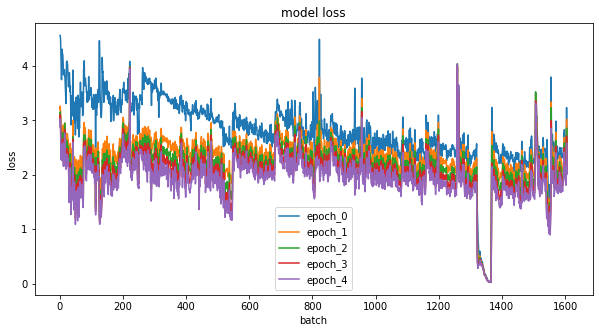

In [73]:
# learning rate = 0.0001
# batch size = 128
plot_loss(losses_per_batch, 'loss', 'batch', 5)

### Several ideas came into my mind after these two training sessions:
### 1) The less batch size we use, the more noise we get.
### 2) Gradient explosions get more expressed with a smaller learning rate. 
### 3) First 600 batches defines the way training goes. 

## Last two items caused by dirty data. I checked those batches and they are terrible for training!

### These batches have a lot of magic numbers, repetative code sections, macroses and many other low-level things. I suggest it simplifies developing but It definetly make it harder for NN to understand the data. More over, I (not an AI) struggle to understand that code.

### I will just delete these bad sections from source code. I would like to get it done automatically but I don't actually know how.

### So I cut big commentaries (added code in the beginning), removed all code from json repo (it is extremely repetitive and macrosed), deleted asm pieces and so on and so on.

# Also I realized that I should NOT pass sequences in the order they are in repos. But why?

## When cleaning data I noticed that there are much more local language (e.g. style guided code) in consecutive pieces of code. It will lead gradient to shift away from true gradient of C++ code. That is exactly what happend in first 600 batches. The solution is shuffle batches.

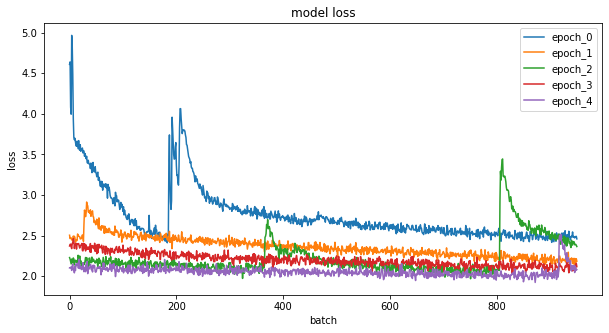

In [153]:
# learning rate = 0.001
plot_loss(losses_per_batch, 'loss', 'batch', 5)

### I like this picture! But model still underfitting data. At least it needs more epochs as every batch have slightly different distribution.

### I will take $\frac{1}{16}$ of my data in order to speed up training.

## Also I fixed some bugs in data cleanse.

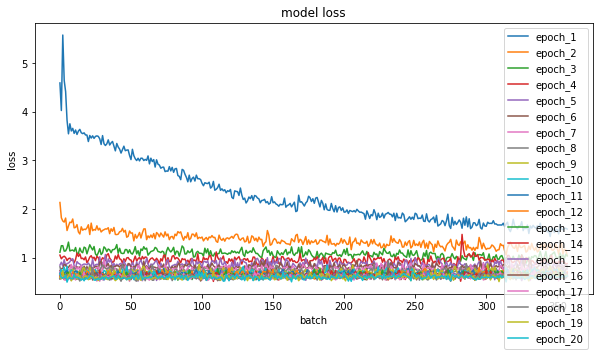

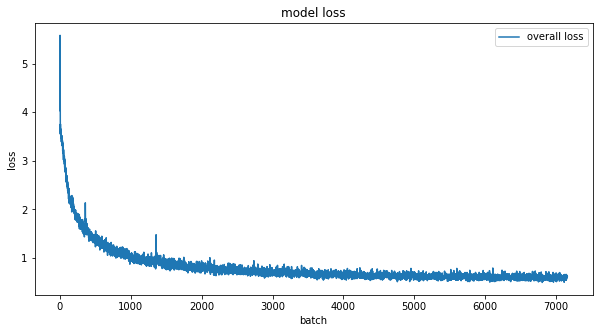

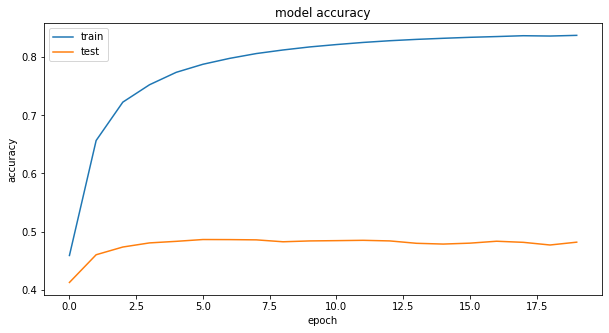

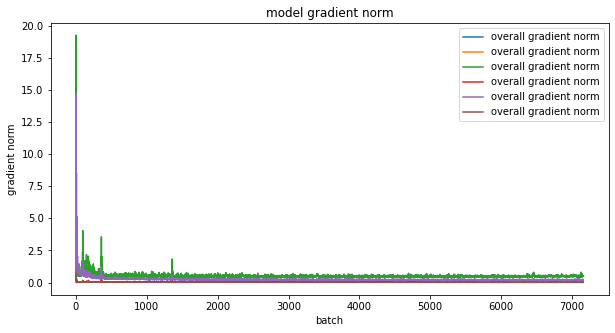

In [87]:
# batch_size = 64
# sequence_length = 150
# learning rate = 0.001
# untis = 1024

plot(rnn_result.loss_per_epoch, 'loss', 'batch', [f'epoch_{i+1}' for i in range(20)])

loss_per_batch = []
for epoch in rnn_result.loss_per_epoch:
    loss_per_batch.extend(epoch)

plot([loss_per_batch], 'loss', 'batch', ['overall loss'])

plot(
    [rnn_result.train_accuracy_per_epoch, rnn_result.test_accuracy_per_epoch],
    'accuracy',
    'epoch',
    ['train', 'test']
)

plot([rnn_result.grads_per_batch], 'gradient norm', 'batch', ['overall gradient norm'])

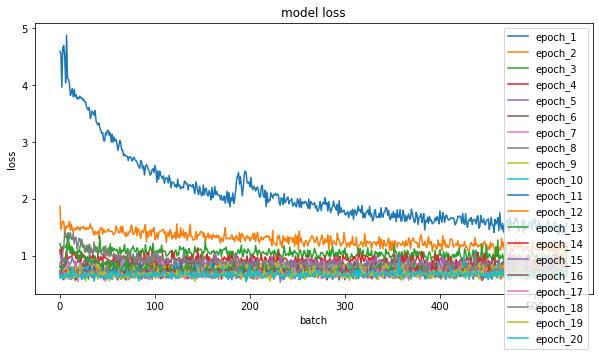

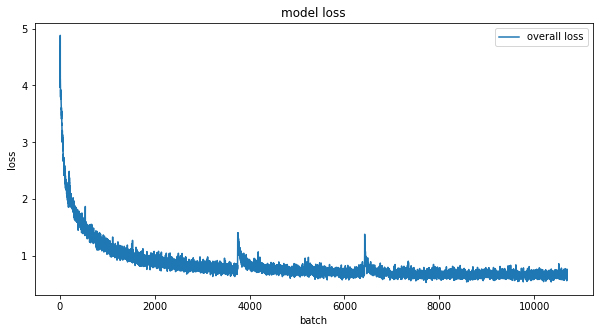

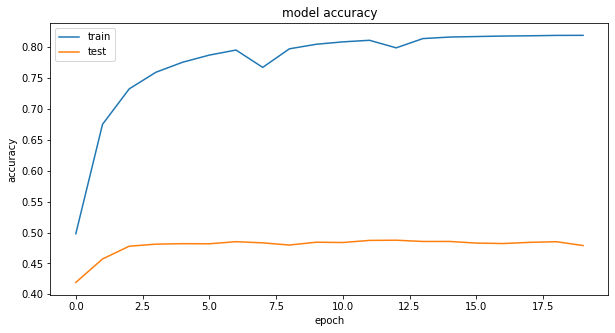

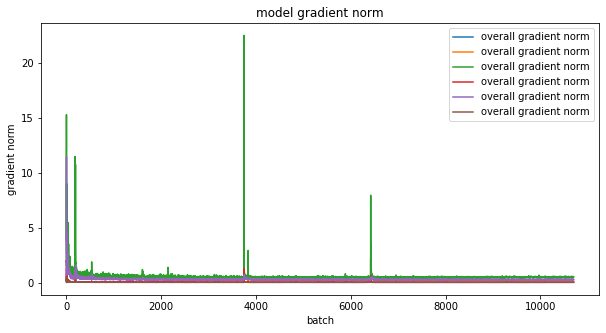

In [162]:
# batch_size = 64
# sequence_length = 100
# learning rate = 0.001
# untis = 1024

plot(rnn_result.loss_per_epoch, 'loss', 'batch', [f'epoch_{i+1}' for i in range(20)])

loss_per_batch = []
for epoch in rnn_result.loss_per_epoch:
    loss_per_batch.extend(epoch)

plot([loss_per_batch], 'loss', 'batch', ['overall loss'])

plot(
    [rnn_result.train_accuracy_per_epoch, rnn_result.test_accuracy_per_epoch],
    'accuracy',
    'epoch',
    ['train', 'test']
)

plot([rnn_result.grads_per_batch], 'gradient norm', 'batch', ['overall gradient norm'])

### 1) I definetly cant get 100% accuracy because you cant predict some code based on completely different code
### 2) Model needs olny 5 epochs to understand some of C++ syntax (syntax is about 40% of code when there is no madness with templates)
### 3) There are several gradient explosions but they do not affect learning much so I won't perform gradient clipping

## I don't think that in case of simple RNN It makes sense to carry out hyperparameter tuning as we got good enough result.

# RNN Text generation

In [166]:
model_rnn = build_rnn(rnn_units, embedding_dim, 0.001, p_batch_size=1)

In [167]:
model_rnn.set_weights(tf.keras.models.load_model('./rnn_model/').get_weights())

In [13]:
def generate_text(model, start_string, temperature=1.0, num_generate=1000):
  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [198]:
print(generate_text(model_rnn, '#include ', 0.8, 500))

#include <srs_app_utility.hpp>
#include <srs_kernel_log.hpp>
#include <srs_protocol_amf0.hpp>
#include <srs_app_dispaddr = IM_FLOOR(window* window, ImFontStyle* stream)
{
    srs_error_t err = srs_success;
    
    while (n++)
        ISLPER_ASSERT_SUCCESS(conf.parse(&buf));
    EXPECT_STREQ("arg1", dir0.arg1().c_str());
    EXPECT_EQ(0, (int)dir0.args.size());
    EXPECT_EQ(0, (int)dir0.directives.size());

        // for head
        // warning 
#endif

//---------
// [SECTION
//---------

// the segm



## We can see that It looks like code: some brackets match, It does not assign variables to literals, It tries to put semicolons at the end of line where it is needed. But there is definitely lack of rules.

# One layer LSTM construction

In [141]:
def build_lstm_1l(p_units, 
              p_embedding_dim,  
              p_learning_rate=0.001,
              p_vocab_size=vocab_size,
              p_batch_size=batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            p_vocab_size, 
            p_embedding_dim,
            batch_input_shape=[p_batch_size, None]
        ),
        tf.keras.layers.LSTM(
            p_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True # only for less complicated text generation
        ),
        tf.keras.layers.Dense(p_vocab_size)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(p_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [146]:
model = build_lstm_1l(512, 256)

In [147]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (64, None, 256)           24832     
_________________________________________________________________
lstm_3 (LSTM)                (64, None, 512)           1574912   
_________________________________________________________________
dense_11 (Dense)             (64, None, 97)            49761     
Total params: 1,649,505
Trainable params: 1,649,505
Non-trainable params: 0
_________________________________________________________________


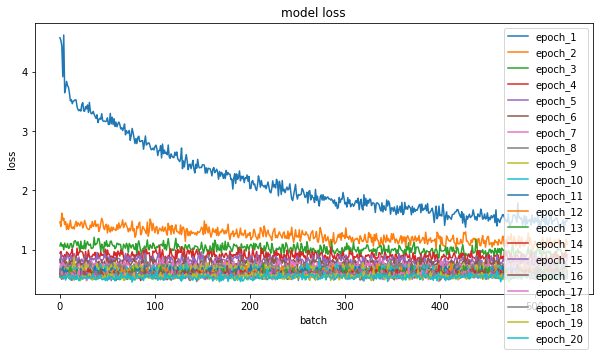

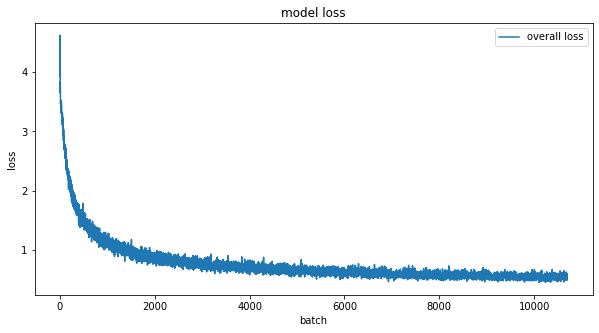

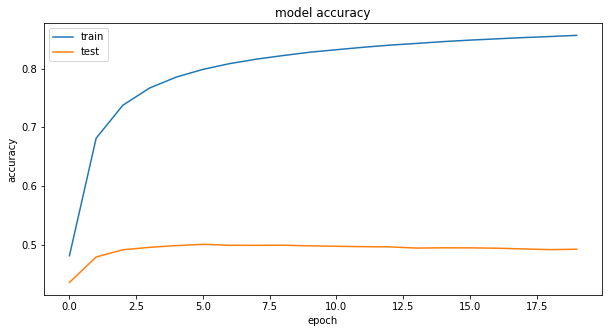

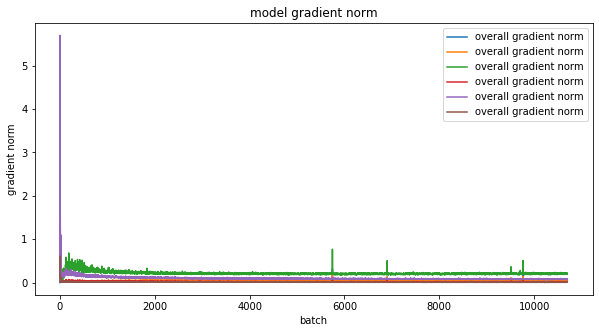

In [170]:
# batch_size = 64
# sequence_length = 100
# learning rate = 0.001
# untis = 1024

plot(lstm_1l_result.loss_per_epoch, 'loss', 'batch', [f'epoch_{i+1}' for i in range(20)])

loss_per_batch = []
for epoch in lstm_1l_result.loss_per_epoch:
    loss_per_batch.extend(epoch)

plot([loss_per_batch], 'loss', 'batch', ['overall loss'])

plot(
    [lstm_1l_result.train_accuracy_per_epoch, lstm_1l_result.test_accuracy_per_epoch],
    'accuracy',
    'epoch',
    ['train', 'test']
)

plot([lstm_1l_result.grads_per_batch], 'gradient norm', 'batch', ['overall gradient norm'])

In [169]:
model_lstm_1l = build_lstm_1l(512, 256, 0.001)
model_lstm_1l.fit(train, epochs=6, validation_data=test)
model_lstm_1l.save('./lstm_1l/')

Epoch 1/6
535/535 [==============================] - 108s 202ms/step - loss: 2.1758 - sparse_categorical_accuracy: 0.4714 - val_loss: 2.4339 - val_sparse_categorical_accuracy: 0.4292
Epoch 2/6
535/535 [==============================] - 112s 210ms/step - loss: 1.2713 - sparse_categorical_accuracy: 0.6738 - val_loss: 2.2859 - val_sparse_categorical_accuracy: 0.4747
Epoch 3/6
535/535 [==============================] - 113s 211ms/step - loss: 1.0349 - sparse_categorical_accuracy: 0.7321 - val_loss: 2.2594 - val_sparse_categorical_accuracy: 0.4906
Epoch 4/6
535/535 [==============================] - 113s 211ms/step - loss: 0.9143 - sparse_categorical_accuracy: 0.7619 - val_loss: 2.2835 - val_sparse_categorical_accuracy: 0.4947
Epoch 5/6
535/535 [==============================] - 113s 211ms/step - loss: 0.8375 - sparse_categorical_accuracy: 0.7812 - val_loss: 2.2924 - val_sparse_categorical_accuracy: 0.5008
Epoch 6/6
535/535 [==============================] - 113s 212ms/step - loss: 0.7826 -

In [171]:
model_lstm_1l = build_lstm_1l(512, 256, 0.001, p_batch_size=1)
model_lstm_1l.set_weights(tf.keras.models.load_model('./lstm_1l/').get_weights())

# 1 layer LSTM text generation

In [183]:
print(generate_text(model_lstm_1l, '#include ', 0.8, 500))

#include   
    if ((err = connect_and_from_cache()) != srs_success) {
        return srs_error_wrap(err, "init change");
        if (!conf) {
            return srs_error_wrap(err, "write fram set frame");
        }
    }
    
    return err;
}

srs_error_t SrsMpsListenerStream::cw_initialize(SrsConfDirective* conf)
{
    return conf->arg0();
}

srs_error_t SrsTsPayloadPES::recv_utility()
{
    return SrsMp4FullBox::nb_header();
                    obj->set("addr", SrsJsonAny::str(req->app.x_read_srs_po


## We can see that LSTM learned structure itself much better than RNN but lack rule of include command. Maybe this rule has less priority.

# Two layer LSTM construction

In [214]:
def build_lstm_2l(p_units, 
              p_embedding_dim,  
              p_learning_rate=0.001,
              p_vocab_size=vocab_size,
              p_batch_size=batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            p_vocab_size, 
            p_embedding_dim,
            batch_input_shape=[p_batch_size, None]
        ),
        tf.keras.layers.LSTM(
            p_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True # only for less complicated text generation
        ),
        tf.keras.layers.LSTM(
            p_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True # only for less complicated text generation
        ),
        tf.keras.layers.Dense(p_vocab_size)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(p_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [242]:
model_lstm_2l = build_lstm_2l(300, 256, 0.001)
model_lstm_2l.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (64, None, 256)           24832     
_________________________________________________________________
lstm_32 (LSTM)               (64, None, 300)           668400    
_________________________________________________________________
lstm_33 (LSTM)               (64, None, 300)           721200    
_________________________________________________________________
dense_35 (Dense)             (64, None, 97)            29197     
Total params: 1,443,629
Trainable params: 1,443,629
Non-trainable params: 0
_________________________________________________________________


In [215]:
# sequence length = 250
model_lstm_2l = build_lstm_2l(300, 256, 0.001)
model_lstm_2l.fit(train, epochs=10, validation_data=test)

Epoch 1/10
215/215 [==============================] - 103s 479ms/step - loss: 2.8891 - sparse_categorical_accuracy: 0.3126 - val_loss: 2.8480 - val_sparse_categorical_accuracy: 0.3363
Epoch 2/10
215/215 [==============================] - 104s 485ms/step - loss: 1.9188 - sparse_categorical_accuracy: 0.5129 - val_loss: 2.5121 - val_sparse_categorical_accuracy: 0.4034
Epoch 3/10
215/215 [==============================] - 106s 493ms/step - loss: 1.4938 - sparse_categorical_accuracy: 0.6162 - val_loss: 2.3844 - val_sparse_categorical_accuracy: 0.4339
Epoch 4/10
215/215 [==============================] - 107s 495ms/step - loss: 1.2546 - sparse_categorical_accuracy: 0.6765 - val_loss: 2.3199 - val_sparse_categorical_accuracy: 0.4560
Epoch 5/10
215/215 [==============================] - 107s 495ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.7157 - val_loss: 2.2966 - val_sparse_categorical_accuracy: 0.4691
Epoch 6/10
215/215 [==============================] - 106s 491ms/step - loss: 0.

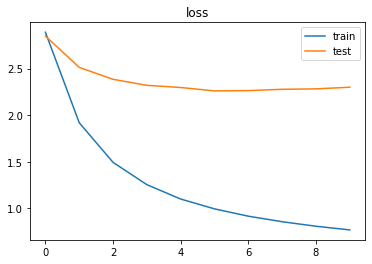

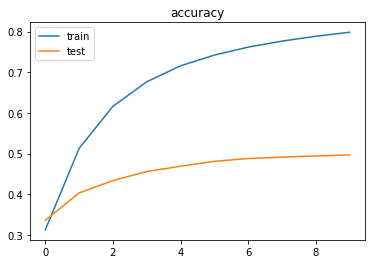

In [216]:
plt.plot(model_lstm_2l.history.history['loss'], label='train')
plt.plot(model_lstm_2l.history.history['val_loss'], label='test')
plt.title('loss')
plt.legend()
plt.show()
plt.plot(model_lstm_2l.history.history['sparse_categorical_accuracy'], label='train')
plt.plot(model_lstm_2l.history.history['val_sparse_categorical_accuracy'], label='test')
plt.title('accuracy')
plt.legend()
plt.show()

In [244]:
model_lstm_2l.save('./lstm_2l/')

INFO:tensorflow:Assets written to: ./lstm_2l/assets


In [246]:
model_lstm_2l = build_lstm_2l(300, 256, 0.001, p_batch_size=1)
model_lstm_2l.set_weights(tf.keras.models.load_model('./lstm_2l/').get_weights())

In [261]:
print(generate_text(model_lstm_2l, '#include ', 0.8, 500))

#include <srs_app_config.hpp>
#include <srs_kernel_utility.hpp>
#include <srs_app_stack.hpp>
#include <srs_kernel_utility.hpp>
#include <srs_protocol_utility.hpp>
#include <srs_servoc_constermate.hpp>

SrsServer::SrsHttpConn()
{
    srs_freep(req);
    req.string();
    s.pull();
    
    std::string rtm;
    if ((err = br->ensubeccess_http_bandine_allow()) != srs_success) {
        return srs_error_wrap(err, "get file");
    }
    
    return err;
}

srs_error_t SrsDvr::on_reload_vhost_add(string vhost)


# GRU construction

In [17]:
def build_gru(p_units, 
              p_embedding_dim,  
              p_learning_rate=0.001,
              p_vocab_size=vocab_size,
              p_batch_size=batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            p_vocab_size, 
            p_embedding_dim,
            batch_input_shape=[p_batch_size, None]
        ),
        tf.keras.layers.GRU(
            p_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True # only for less complicated text generation
        ),
        tf.keras.layers.Dense(p_vocab_size)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(p_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [211]:
model_gru = build_gru(560, 256)
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (64, None, 256)           24832     
_________________________________________________________________
gru_3 (GRU)                  (64, None, 560)           1374240   
_________________________________________________________________
dense_3 (Dense)              (64, None, 97)            54417     
Total params: 1,453,489
Trainable params: 1,453,489
Non-trainable params: 0
_________________________________________________________________


In [212]:
# sequence length = 250
model_gru.fit(train, epochs=10, validation_data=test)

Epoch 1/10
215/215 [==============================] - 99s 460ms/step - loss: 2.6795 - sparse_categorical_accuracy: 0.3747 - val_loss: 2.6604 - val_sparse_categorical_accuracy: 0.3757
Epoch 2/10
215/215 [==============================] - 94s 436ms/step - loss: 1.6261 - sparse_categorical_accuracy: 0.5873 - val_loss: 2.4165 - val_sparse_categorical_accuracy: 0.4393
Epoch 3/10
215/215 [==============================] - 97s 450ms/step - loss: 1.2062 - sparse_categorical_accuracy: 0.6904 - val_loss: 2.3235 - val_sparse_categorical_accuracy: 0.4723
Epoch 4/10
215/215 [==============================] - 97s 449ms/step - loss: 1.0000 - sparse_categorical_accuracy: 0.7410 - val_loss: 2.3072 - val_sparse_categorical_accuracy: 0.4857
Epoch 5/10
215/215 [==============================] - 97s 451ms/step - loss: 0.8811 - sparse_categorical_accuracy: 0.7704 - val_loss: 2.3122 - val_sparse_categorical_accuracy: 0.4921
Epoch 6/10
215/215 [==============================] - 97s 452ms/step - loss: 0.8019 -

In [217]:
model_gru.save('./gru/')

INFO:tensorflow:Assets written to: ./gru/assets


In [218]:
model_gru = build_gru(560, 256, p_batch_size=1)
model_gru.set_weights(tf.keras.models.load_model('./gru/').get_weights())

In [226]:
print(generate_text(model_gru, '#include ', 0.8, 500))

#include <srs_app_ecensed.hpp>
#include <srs_app_config.hpp>
#include <srs_app_refer.hpp>

SrsTcpClient::~SrsUnparequeue(encidel_fileReader, req)) != srs_success) {
        return srs_error_wrap(err, "read box");
    }
    
    return err;
}

srs_error_t SrsBufferFlv::UdistinSoutcedRectPushID(const char* default_vhost)
{
    ImGuiContext& g = *GImGui;
    g.NextWindowData.Fleas();
}

void ImGui::CheckCount_track_ImpuvIdxodsDistBox(void * 0x6c)
        case ImGuiCol_TextItemIdx = (const char* text = strea


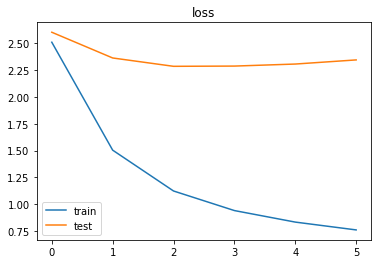

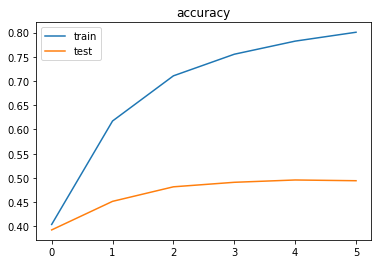

In [123]:
plt.plot(model_gru.history.history['loss'], label='train')
plt.plot(model_gru.history.history['val_loss'], label='test')
plt.title('loss')
plt.legend()
plt.show()
plt.plot(model_gru.history.history['sparse_categorical_accuracy'], label='train')
plt.plot(model_gru.history.history['val_sparse_categorical_accuracy'], label='test')
plt.title('accuracy')
plt.legend()
plt.show()